# **Mini Transformer for Dialogue Generation**

## **Ringkasan Teori**

Decoder-Only Transformer: hanya decoder stack dengan
- Token & Positional Embedding
- Masked Multi-Head Self-Attention
- Feed-Forward Network
- Residual + LayerNorm
 
Varian:
- vanilla_small / vanilla_big
- relpos_small / relpos_big (dengan relative positional bias)

## **Setup**

In [ ]:
import math, random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import evaluate
import pandas as pd

In [32]:
def set_seed(s=42):
    random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
set_seed()

In [33]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## **Config**

In [34]:
MAX_SEQ_LEN        = 64
BATCH_SIZE         = 32
NUM_SAMPLES_TRAIN  = 5000
NUM_SAMPLES_TEST   = 200
VAL_SPLIT_RATIO    = 0.1
LEARNING_RATE      = 1e-4

## **Data Loading & EDA**

In [35]:
# load dataset
ds = load_dataset("li2017dailydialog/daily_dialog")
train_raw = ds["train"]["dialog"][:NUM_SAMPLES_TRAIN]
test_raw  = ds["test"]["dialog"][:NUM_SAMPLES_TEST]

In [36]:
# tampilkan 5 contoh
print(">>> 5 contoh train:")
for conv in train_raw[:5]:
    print(" ", conv)
print("\n>>> 5 contoh test:")
for conv in test_raw[:5]:
    print(" ", conv)

>>> 5 contoh train:
  ['Say , Jim , how about going for a few beers after dinner ? ', ' You know that is tempting but is really not good for our fitness . ', ' What do you mean ? It will help us to relax . ', " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ", " I guess you are right.But what shall we do ? I don't feel like sitting at home . ", ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . ', " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . ", ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . ', " Good.Let ' s go now . ", ' All right . ']
  ['Can you do push-ups ? ', " Of course I can . It's a piece of cake ! Believe it or not , I can do 30 push-ups a minute . ", " Really ? I think that's impossible ! ", ' You mean 30 push-ups ? ', ' Yeah ! ', 

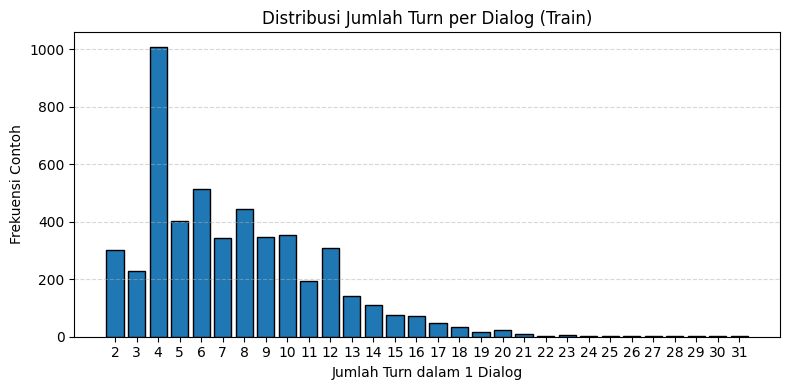

In [37]:
lengths = [len(c) for c in train_raw]
dist    = Counter(lengths)
turns, freqs = zip(*sorted(dist.items()))

# Plot
plt.figure(figsize=(8,4))
plt.bar(turns, freqs, edgecolor='k')
plt.xlabel("Jumlah Turn dalam 1 Dialog")
plt.ylabel("Frekuensi Contoh")
plt.title("Distribusi Jumlah Turn per Dialog (Train)")
plt.xticks(turns)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **Data Preprocessing (Vocab & Dataset)**

In [38]:
# bangun vocab
token_freq = {}
for conv in train_raw:
    for tok in " [SEP] ".join(conv).split():
        token_freq[tok] = token_freq.get(tok,0) + 1

vocab = ["<pad>","<bos>","<eos>","[SEP]"] + sorted(token_freq, key=token_freq.get, reverse=True)
token2id = {t:i for i,t in enumerate(vocab)}
vocab_size = len(vocab)

In [39]:
# dataset class
class DialogDataset(Dataset):
    def __init__(self, dialogs, tok2id, max_len):
        self.data = []
        for conv in dialogs:
            seq = ["<bos>"] + conv + ["<eos>"]
            ids = [tok2id.get(t,tok2id["<pad>"]) for t in seq]
            ids = ids[:max_len]
            ids += [tok2id["<pad>"]] * (max_len - len(ids))
            self.data.append(torch.tensor(ids))
    def __len__(self): return len(self.data)
    def __getitem__(self, i):
        x = self.data[i][:-1]
        y = self.data[i][1:]
        return x, y

In [40]:
# split train/val
full_ds = DialogDataset(train_raw, token2id, MAX_SEQ_LEN)
val_size = int(len(full_ds) * VAL_SPLIT_RATIO)
train_size = len(full_ds) - val_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

## **Arsitektur Transformer**

In [41]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model%num_heads==0
        self.d_head    = d_model//num_heads
        self.num_heads = num_heads
        self.qkv       = nn.Linear(d_model, 3*d_model)
        self.proj      = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.proj_drop = nn.Dropout(dropout)
    def forward(self, x):
        B,T,D = x.shape
        q,k,v = self.qkv(x).chunk(3,-1)
        q = q.view(B,T,self.num_heads,self.d_head).transpose(1,2)
        k = k.view(B,T,self.num_heads,self.d_head).transpose(1,2)
        v = v.view(B,T,self.num_heads,self.d_head).transpose(1,2)
        scores = (q @ k.transpose(-2,-1)) / math.sqrt(self.d_head)
        mask   = torch.tril(torch.ones(T,T,device=x.device)).unsqueeze(0).unsqueeze(0)
        scores = scores.masked_fill(mask==0, float('-inf'))
        attn   = torch.softmax(scores, dim=-1)
        attn   = self.attn_drop(attn)
        out    = (attn @ v).transpose(1,2).contiguous().view(B,T,D)
        return self.proj_drop(self.proj(out))

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.GELU(),
            nn.Linear(d_ff,d_model),
            nn.Dropout(dropout)
        )
    def forward(self,x): return self.net(x)

class DecoderBlock(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln1  = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model,heads,dropout)
        self.ln2  = nn.LayerNorm(d_model)
        self.ff   = FeedForward(d_model,d_ff,dropout)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x
class MultiHeadSelfAttentionRelPos(MultiHeadSelfAttention):
    def __init__(self, d_model, num_heads, max_len, dropout=0.1):
        super().__init__(d_model, num_heads, dropout)
        self.max_len  = max_len
        # bias untuk posisi relatif dari -(max_len-1) sampai +(max_len-1)
        self.rel_bias = nn.Parameter(torch.zeros(num_heads, 2*max_len-1))
        coords = torch.arange(max_len)
        rel_idx = coords[None, :] - coords[:, None] + (max_len - 1)  # shape (max_len, max_len)
        self.register_buffer('rel_idx', rel_idx)

    def forward(self, x):
        B, T, D = x.shape
        # Dapatkan Q,K,V seperti biasa
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.d_head).transpose(1, 2)

        # hitung attention scores
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)  # (B, H, T, T)

        # ambil hanya bias [0:T,0:T]
        rel_bias_T = self.rel_bias[:, self.rel_idx[:T, :T]]         # (H, T, T)
        scores = scores + rel_bias_T.unsqueeze(0)                   # (B, H, T, T)

        # mask causal
        mask = torch.tril(torch.ones(T, T, device=x.device))
        mask = mask.unsqueeze(0).unsqueeze(0)                       # (1,1,T,T)
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = torch.softmax(scores, dim=-1)
        attn = self.attn_dropout(attn)
        out  = (attn @ v).transpose(1, 2).contiguous().view(B, T, D)
        return self.proj_dropout(self.proj(out))

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.embed   = nn.Embedding(cfg['vocab_size'],cfg['d_model'])
        self.pos_enc = PositionalEncoding(cfg['d_model'],cfg['max_len'])
        self.drop    = nn.Dropout(cfg['dropout'])
        self.layers  = nn.ModuleList()
        for _ in range(cfg['num_layers']):
            block = DecoderBlock(cfg['d_model'],cfg['num_heads'],cfg['d_ff'],cfg['dropout'])
            if cfg.get('relpos',False):
                block.attn = MultiHeadSelfAttentionRelPos(
                    cfg['d_model'],cfg['num_heads'],cfg['max_len'],cfg['dropout'])
            self.layers.append(block)
        self.ln_f = nn.LayerNorm(cfg['d_model'])
        self.head = nn.Linear(cfg['d_model'],cfg['vocab_size'],bias=False)
    def forward(self,x):
        x = self.embed(x)*math.sqrt(x.size(-1))
        x = self.pos_enc(x)
        x = self.drop(x)
        for blk in self.layers: x = blk(x)
        x = self.ln_f(x)
        return self.head(x)

In [45]:
# Cell 13. Setup evaluasi
rouge  = evaluate.load("rouge")
bleu   = evaluate.load("bleu")
meteor = evaluate.load("meteor")


# Cell 14. Greedy decode function
def greedy_generate(model, ids, max_new=32):
    model.eval()
    out = ids.to(DEVICE)
    with torch.no_grad():
        for _ in range(max_new):
            logits = model(out)
            nt = logits[:, -1].argmax(dim=-1, keepdim=True)
            out = torch.cat([out, nt], dim=-1)
            if nt.item() == token2id["<eos>"]:
                break
    return out

Using the latest cached version of the module from /home/xmriz/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--rouge/b01e0accf3bd6dd24839b769a5fda24e14995071570870922c71970b3a6ed886 (last modified on Thu May  1 00:01:29 2025) since it couldn't be found locally at evaluate-metric--rouge, or remotely on the Hugging Face Hub.


ModuleNotFoundError: No module named 'absl'

## **Pelatihan & Validasi**

In [42]:
experiments = [
    {'name':'vanilla_small','num_layers':2,'d_model': 64,'num_heads':2,'d_ff':256,'relpos':False},
    {'name':'vanilla_big',  'num_layers':2,'d_model':128,'num_heads':4,'d_ff':512,'relpos':False},
    {'name':'relpos_small', 'num_layers':2,'d_model': 64,'num_heads':2,'d_ff':256,'relpos':True},
    {'name':'relpos_big',   'num_layers':2,'d_model':128,'num_heads':4,'d_ff':512,'relpos':True},
]

In [43]:
train_losses, val_losses = {}, {}
for cfg in experiments:
    print(f"\n>>> Training {cfg['name']}")
    conf = {'vocab_size':vocab_size,'max_len':MAX_SEQ_LEN,'dropout':0.1, **cfg}
    model = DecoderOnlyTransformer(conf).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE)
    crit  = nn.CrossEntropyLoss(ignore_index=token2id["<pad>"])

    tl, vl = [], []
    for epoch in range(1, 6):  # e.g. 5 epochs
        # train
        model.train(); total, n = 0,0
        for x,y in train_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss   = crit(logits.view(-1,vocab_size), y.view(-1))
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item(); n+=1
        tl.append(total/n)

        # valid
        model.eval(); total, n = 0,0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                logits = model(x)
                loss   = crit(logits.view(-1,vocab_size), y.view(-1))
                total += loss.item(); n+=1
        vl.append(total/n)
        print(f" Epoch {epoch}: train={tl[-1]:.4f}, val={vl[-1]:.4f}")

    train_losses[cfg['name']] = tl
    val_losses[cfg['name']]   = vl


>>> Training vanilla_small
 Epoch 1: train=8.1785, val=5.4192
 Epoch 2: train=3.8731, val=2.2482
 Epoch 3: train=1.6474, val=0.7681
 Epoch 4: train=0.5842, val=0.2710
 Epoch 5: train=0.2468, val=0.1318

>>> Training vanilla_big
 Epoch 1: train=4.5447, val=0.8939
 Epoch 2: train=0.4945, val=0.1414
 Epoch 3: train=0.1250, val=0.0562
 Epoch 4: train=0.0596, val=0.0312
 Epoch 5: train=0.0358, val=0.0201

>>> Training relpos_small


AttributeError: 'MultiHeadSelfAttentionRelPos' object has no attribute 'attn_dropout'

## **Visualisasi Loss**

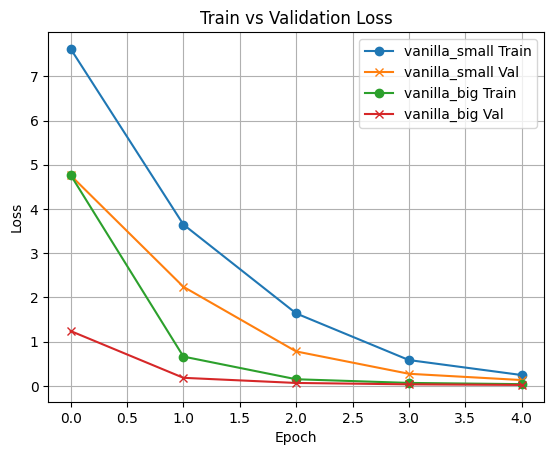

In [ ]:
for name in train_losses:
    plt.plot(train_losses[name], marker='o', label=f"{name} Train")
    plt.plot(val_losses[name],   marker='x', label=f"{name} Val")
plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## **Inference & Evaluation**

In [ ]:
# Cell 7: Greedy decoding (sudah ada) dan evaluasi test set
preds, refs = [], []
for conv in test_raw:
    prompt = "<bos> " + " [SEP] ".join(conv[:-1]) + " <eos>"
    ids    = [token2id.get(t,token2id["<pad>"]) for t in prompt.split()][:MAX_SEQ_LEN]
    ids   += [token2id["<pad>"]] * (MAX_SEQ_LEN - len(ids))
    input_tensor = torch.tensor([ids]).to(DEVICE)

    out_ids = greedy_generate(model, input_tensor, max_new=32)
    toks    = [vocab[i] for i in out_ids[0].cpu().tolist()]

    # bersihkan <bos>, <pad>, hingga <eos>
    gen = []
    for tok in toks:
        if tok in ("<bos>","<pad>"): continue
        if tok == "<eos>": break
        gen.append(tok)
    preds.append(" ".join(gen).replace("[SEP]"," ").strip())
    refs.append(conv[-1])

# hitung metrik
rouge_res  = rouge.compute(predictions=preds, references=refs)
bleu_res   = bleu.compute(
    predictions=[p.split() for p in preds],
    references=[[r.split()] for r in refs]
)
meteor_res = meteor.compute(predictions=preds, references=refs)

print("=== Test Set Evaluation ===")
print("ROUGE:", rouge_res)
print("BLEU: ", bleu_res)
print("METEOR:", meteor_res)

# tampilkan 5 contoh
print("\n=== Contoh Generasi ===")
for i in range(5):
    print(f"\nContoh {i+1}")
    print(" Prompt   :", " | ".join(test_raw[i][:-1]))
    print(" Reference:", refs[i])
    print(" Prediksi :", preds[i])


## **Analisis Hasil & Kesimpulan**

In [ ]:
# Cell 8: Ranking model per validation loss
best_val = {name: min(val_losses[name]) for name in val_losses}
df_rank  = pd.DataFrame.from_dict(best_val, orient='index', columns=['BestValLoss'])
df_rank  = df_rank.reset_index().rename(columns={'index':'Experiment'})
df_rank  = df_rank.sort_values('BestValLoss').reset_index(drop=True)

print("=== Ranking Model (by Best Val Loss) ===")
print(df_rank.to_string(index=False))

# Ringkasan metrik test set (ambil model terbaik)
best_model = df_rank.loc[0, 'Experiment']
print(f"\nModel terbaik: {best_model}")
print(f"Test ROUGE-1 F1 : {rouge_res['rouge1']:.4f}")
print(f"Test BLEU       : {bleu_res['bleu']:.4f}")
print(f"Test METEOR     : {meteor_res['meteor']:.4f}")

# Kesimpulan
print("\n=== Kesimpulan ===")
print(f"Dari kurva loss dan metrik test, varian **{best_model}** memberikan trade-off terbaik antara training stability dan kualitas generasi dialog.")
